In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from data_utils import *

In [5]:
PATH = '/home/lguirardel/hdd2/cooper/scSNPseq_data'
GT_PATH = PATH + '/genotyped_experiment'
NON_GT_PATH = PATH + '/non_genotyped_base_editor_experiment'

# Load data

In [7]:
gt_cells = pd.read_csv(f'{PATH}/metadata_genotyped_experiment.csv')
gt_count = pd.read_csv(f'{PATH}/umi_counts_genotyped_experiment.mtx.gz',  skiprows=2, header=None, sep=' ', names=['gene', 'cell', 'count'])
gt_count[['gene', 'cell']] -= 1 #1-based mtx format

In [8]:
gt_cells.rename(columns={'X':'cell_barcode'}, inplace=True)
gt_count['cell_name'] = gt_cells.iloc[gt_count.cell]['cell_barcode'].values

In [9]:
gt_count

,gene,cell,count,cell_name
0,36,0,1,AAACCTGAGATCCCGC-1
1,44,0,2,AAACCTGAGATCCCGC-1
2,59,0,1,AAACCTGAGATCCCGC-1
3,60,0,3,AAACCTGAGATCCCGC-1
4,71,0,1,AAACCTGAGATCCCGC-1
...,...,...,...,...
49846876,34790,18977,12,TTTGTCATCTGAAAGA-1
49846877,34791,18977,12,TTTGTCATCTGAAAGA-1
49846878,34792,18977,10,TTTGTCATCTGAAAGA-1
49846879,34793,18977,5,TTTGTCATCTGAAAGA-1


In [10]:
gt_cells

,cell_barcode,sizeFactor,gRNA,iBAR,gRNA_iBAR,puro,gRNA_iBAR_seq,edited,facs_z_score,prolif_z_score,...,cluster,facs_z_score_edited,prolif_z_score_edited,gene,amplicon,consequence,any_homozygous,predicted_consequence,GT,diffusion_score
0,AAACCTGAGATCCCGC-1,0.870543,1083718323,iBAR_1079,1083718323-iBAR_1079,NaN,1083718323-CTTGCA,False,NaN,NaN,...,not_LoF,NaN,NaN,SLC22A12,not_covered,WT,False,WT,WT,-0.003780
1,AAACCTGAGCCATCGC-1,2.057254,1083718323,iBAR_1079,1083718323-iBAR_1079,NaN,1083718323-CTTGCA,False,NaN,NaN,...,not_LoF,NaN,NaN,SLC22A12,not_covered,WT,False,WT,WT,-0.003731
2,AAACCTGAGTATCTCG-1,1.023186,908510170,iBAR_450,908510170-iBAR_450,NaN,908510170-TCGTTC,True,16.508,10.304,...,LoF,16.508,10.304,JAK1,sanger_AMP15,splice variant,True,splice variant,64844886-1/1/1-C-T;64844887-1/1/1-C-T;64844889...,0.016853
3,AAACCTGAGTCACGCC-1,0.664834,908523461,iBAR_578,908523461-iBAR_578,puroBC_346,908523461-TACTTC,False,0.045,-0.102,...,not_LoF,NaN,NaN,JAK1,not_covered,WT,False,promoter;not_covered,WT,-0.003281
4,AAACCTGCAAGCTGTT-1,0.498058,1053064411,iBAR_3793,1053064411-iBAR_3793,puroBC_361,1053064411-GAGCTT,False,NaN,NaN,...,not_LoF,NaN,NaN,VCP,not_covered,WT,False,WT,WT,-0.003362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18973,TTTGTCATCCACGTGG-1,0.749090,1147859256,iBAR_2519,1147859256-iBAR_2519,puroBC_451,1147859256-ACGCCA,False,NaN,NaN,...,not_LoF,NaN,NaN,DHX8,not_covered,WT,False,WT,WT,-0.003538
18974,TTTGTCATCCCAAGTA-1,0.597425,1083718323,iBAR_1079,1083718323-iBAR_1079,puroBC_590,1083718323-CTTGCA,False,NaN,NaN,...,not_LoF,NaN,NaN,SLC22A12,not_covered,WT,False,WT,WT,-0.003076
18975,TTTGTCATCCGAACGC-1,0.888139,1147550538,iBAR_3093,1147550538-iBAR_3093,NaN,1147550538-GTTCCT,False,NaN,NaN,...,not_LoF,NaN,NaN,KRT38,not_covered,WT,False,WT,WT,-0.004032
18976,TTTGTCATCCGTACAA-1,0.487437,1083718323,iBAR_1079,1083718323-iBAR_1079,puroBC_590,1083718323-CTTGCA,False,NaN,NaN,...,not_LoF,NaN,NaN,SLC22A12,not_covered,WT,False,WT,WT,-0.003582


In [15]:
gt_count = gt_count.pivot(index='cell', columns='gene', values='count').fillna(0)

In [16]:
nongt_cells = pd.read_csv(f'{PATH}/metadata_non_genotyped_experiment.csv')
nongt_count = pd.read_csv(f'{PATH}/umi_counts_non_genotyped_experiment.mtx',  skiprows=2, header=None, sep=' ', names=['gene', 'cell', 'count'])
nongt_count[['gene', 'cell']] -= 1 #1-based mtx format
nongt_count = nongt_count.pivot(index='cell', columns='gene', values='count').fillna(0)

In [17]:
gt_count.shape, nongt_count.shape

((18978, 24665), (43639, 28362))

In [18]:
# NO : genes don't cleanly match
# all_cells = pd.concat([gt_cells, nongt_cells], axis=0) 
# all_count = pd.concat([gt_count, nongt_count], axis=0)

# UMAP

In [16]:
x_temp = PCA(500).fit_transform(nongt_count)
x_temp.shape

(43639, 500)

In [17]:
umap_X = UMAP(n_components=2).fit_transform(x_temp)

/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

(Text(0.5, 0, 'UMAP1'), Text(0, 0.5, 'UMAP2'))

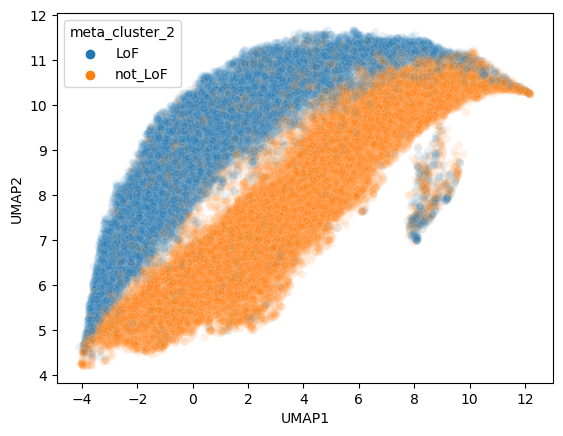

In [19]:
sns.scatterplot(x=umap_X[:, 0], y=umap_X[:, 1], hue=nongt_cells['meta_cluster_2'], alpha=0.1)
plt.xlabel('UMAP1'), plt.ylabel('UMAP2');

/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

<Axes: >

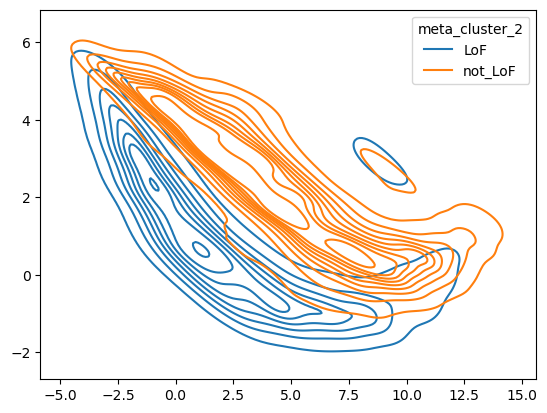

In [15]:
sns.kdeplot(x=umap_X[:, 0], y=umap_X[:, 1], hue=nongt_cells['meta_cluster_2'], )

# Variants

The data is more complicated than Ursu, because we have gene variants rather than protein variants

In [19]:
vc = gt_cells[gt_cells['gene'] == 'JAK1']['GT'].value_counts()
vc

GT
64850886-1/1/1-G-A;64850904-0/0/1-G-A                                          777
WT                                                                             729
64857775-1/1/1-C-T;64857780-1/1/1-C-T                                          567
64850845-1/1/1-G-A;64850846-0/0/1-G-A                                          452
64835404-0/0/1-G-A;64835412-1/1/1-G-A;64835413-1/1/1-G-A;64835433-0/0/1-C-T    422
                                                                              ... 
64845558-1/1/1-C-T;64845559-0/1/1-C-T                                            1
64833534-0/0/1-C-T                                                               1
64873372-0/1/1-G-A;64873374-0/0/1-G-A                                            1
64864991-0/0/1-G-A;64883322-0/1/1-C-T;64883324-1/1/1-C-T;64883325-1/1/1-C-T      1
64966809-1/1/1-C-T;64966811-0/0/1-C-T                                            1
Name: count, Length: 90, dtype: int64

In [20]:
gt_cells.groupby('GT').consequence.nunique().max()

1

In [21]:
df = gt_cells[(gt_cells['gene'] == 'JAK1') & (gt_cells['consequence'] != 'het')]
vc = pd.DataFrame(df['GT'].value_counts().rename('Cell count'))
vc['consequence'] = df.groupby('GT')['consequence'].first()
vc

,Cell count,consequence
GT,,
64850886-1/1/1-G-A;64850904-0/0/1-G-A,777,missense
WT,729,WT
64857775-1/1/1-C-T;64857780-1/1/1-C-T,567,splice variant
64850845-1/1/1-G-A;64850846-0/0/1-G-A,452,stop codon
64835404-0/0/1-G-A;64835412-1/1/1-G-A;64835413-1/1/1-G-A;64835433-0/0/1-C-T,422,missense
...,...,...
64855625-1/1/1-C-T,2,missense
64844185-0/0/1-G-A;64844186-1/1/1-G-A;64844188-0/1/1-G-A;64844218-0/0/1-G-A;64845685-0/0/1-C-T,2,missense
64845558-1/1/1-C-T;64845559-0/1/1-C-T,1,stop codon


/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

Text(0, 0.5, 'Variant count')

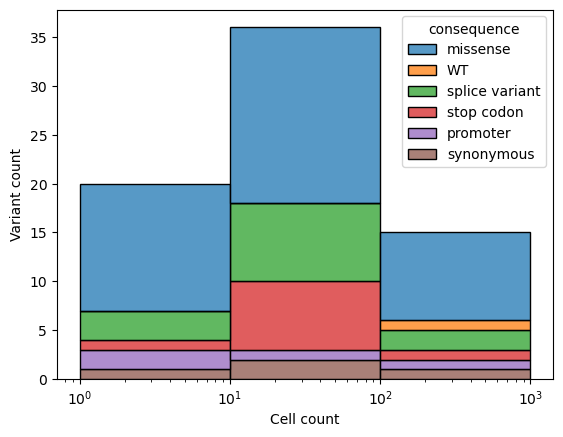

In [22]:
sns.histplot(vc, x='Cell count', hue='consequence', multiple='stack', log_scale=True, bins=[0,1,2,3], )
plt.ylabel('Variant count')

/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

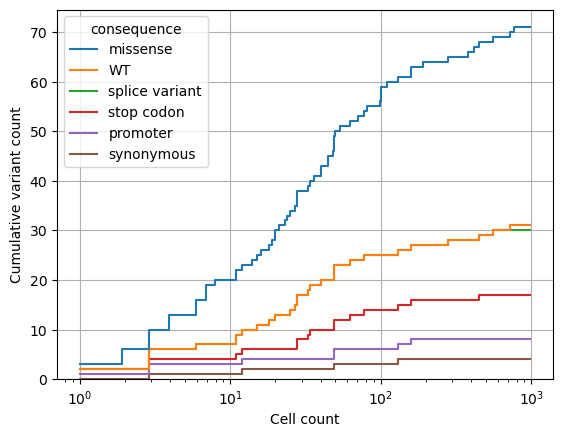

In [39]:
sns.histplot(vc, x='Cell count', hue='consequence',multiple='stack',  
             log_scale=True,  
             cumulative=True, element='step', fill=False,
             bins = np.log10(np.concatenate([np.arange(10**i, 10**(i+1), 10**(i-1)) for i in range(0, 3)])))
plt.ylabel('Cumulative variant count')
plt.grid()

In [40]:
np.concatenate([np.arange(10**i, 10**(i+1), 10**(i-1)) for i in range(0, 3)])[:10]

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])

# Duplicates

In [8]:
vc = gt_cells['X'].value_counts()
gt_cells[gt_cells['X'].isin(vc[vc > 1].index)]

,X,sizeFactor,gRNA,iBAR,gRNA_iBAR,puro,gRNA_iBAR_seq,edited,facs_z_score,prolif_z_score,...,cluster,facs_z_score_edited,prolif_z_score_edited,gene,amplicon,consequence,any_homozygous,predicted_consequence,GT,diffusion_score
67,AAAGCAAGTAAGTGGC-1,1.080049,1083718323,iBAR_1079,1083718323-iBAR_1079,NaN,1083718323-CTTGCA,False,NaN,NaN,...,not_LoF,NaN,NaN,SLC22A12,not_covered,WT,False,WT,WT,-0.003562
109,AAATGCCTCACCCTCA-1,1.057420,908508935,iBAR_2796,908508935-iBAR_2796,puroBC_141,908508935-AAGAAG,True,-0.812,-1.822,...,not_LoF,-0.812,-1.822,JAK1,sanger_AMP7,missense,True,missense,64835391-0/0/1-G-A;64835403-1/1/1-G-A;64835404...,-0.003216
200,AACTCCCCAATGGTCT-1,0.666457,1083718323,iBAR_1079,1083718323-iBAR_1079,puroBC_590,1083718323-CTTGCA,False,NaN,NaN,...,not_LoF,NaN,NaN,SLC22A12,not_covered,WT,False,WT,WT,-0.003220
206,AACTCCCGTACATGTC-1,0.556723,1083718323,iBAR_1079,1083718323-iBAR_1079,NaN,1083718323-CTTGCA,False,NaN,NaN,...,not_LoF,NaN,NaN,SLC22A12,not_covered,WT,False,WT,WT,-0.003679
299,AAGACCTGTGAGTATA-1,1.711813,908510623,iBAR_2398,908510623-iBAR_2398,NaN,908510623-ACCCGC,True,15.516,16.897,...,not_LoF,15.516,16.897,JAK1,sanger_AMP18,missense,True,missense,64847652-0/0/1-C-T;64847659-0/0/1-C-T;64847661...,-0.000217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18547,TTCCCAGAGAAAGTGG-1,0.883034,1083718323,iBAR_1079,1083718323-iBAR_1079,NaN,1083718323-CTTGCA,False,NaN,NaN,...,not_LoF,NaN,NaN,SLC22A12,not_covered,WT,False,WT,WT,-0.003061
18863,TTTACTGCAGTAAGAT-1,0.388814,1083718323,iBAR_1079,1083718323-iBAR_1079,puroBC_590,1083718323-CTTGCA,False,NaN,NaN,...,not_LoF,NaN,NaN,SLC22A12,not_covered,WT,False,WT,WT,-0.003569
18914,TTTGCGCAGGACCACA-1,1.400326,908512102,iBAR_3771,908512102-iBAR_3771,NaN,908512102-GAAGAA,True,13.415,9.545,...,not_LoF,13.415,9.545,JAK1,sanger_AMP21,het,False,stop codon,64857751-0/1/1-G-A,-0.003553
18922,TTTGCGCGTCTCCACT-1,0.560796,1083718323,iBAR_1079,1083718323-iBAR_1079,puroBC_590,1083718323-CTTGCA,False,NaN,NaN,...,not_LoF,NaN,NaN,SLC22A12,not_covered,WT,False,WT,WT,-0.003361


In [13]:
vc = nongt_cells['cell_barcode'].value_counts()
vc[vc>1]

cell_barcode
GTTCATTCACGCGAAA-1    3
TACGGTATCAACACAC-1    3
TTTCCTCAGAGTTGGC-1    3
TCTTTCCAGGAGCGAG-1    3
GTGCTTCTCGGATGTT-1    3
                     ..
CGCCAAGCATCTCCCA-1    2
GCATGTACAAGGACAC-1    2
ACACCAACATTCTTAC-1    2
GATCTAGAGATAGGAG-1    2
GATCTAGAGGGATCTG-1    2
Name: count, Length: 945, dtype: int64

In [14]:
nongt_cells[nongt_cells['cell_barcode'].isin(vc[vc > 1].index)]

,cell_barcode,sizeFactor,gRNA,zscore_FACS,predicted_consequence,zscore_proliferation,target_gene,cluster,meta_cluster_2
13,AAACCTGGTCACACGC-1,1.218057,908511809,17.163,stop codon,12.053,JAK1,4,LoF
23,AAACCTGTCCAAAGTC-1,1.021081,908509644,0.450,missense,-0.238,JAK1,7,not_LoF
53,AAAGATGAGAAAGTGG-1,1.880510,1174235700,NaN,WT,NaN,CSE1L,2,not_LoF
71,AAAGATGGTCGCTTCT-1,1.418805,908510033,9.850,missense,9.977,JAK1,2,not_LoF
75,AAAGATGGTTGTCTTT-1,1.002056,908509424,1.241,synonymous,0.919,JAK1,5,not_LoF
...,...,...,...,...,...,...,...,...,...
43516,TTTACTGGTCCCTTGT-1,0.625083,908510274,18.951,stop codon,12.994,JAK1,1,LoF
43532,TTTATGCCATCACGTA-1,1.145317,908508947,1.615,missense,-3.435,JAK1,6,not_LoF
43548,TTTATGCTCCTAGGGC-1,1.014210,908513963,1.342,synonymous,1.341,JAK1,6,not_LoF
43577,TTTGCGCCAGGTCTCG-1,0.651298,1083718323,NaN,WT,NaN,SLC22A12,3,not_LoF


In [15]:
len(set(gt_cells['X']) & set(nongt_cells['cell_barcode']))

1086